Page 80

In [3]:
# Step 1: Install required libraries
!pip install -q scikit-learn matplotlib seaborn

# Step 2: Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import LabelEncoder

In [4]:
# Step 3: Upload and load file
from google.colab import files
uploaded = files.upload()

df = pd.read_csv(next(iter(uploaded)), encoding='latin1')
df = df[['text', 'target']].dropna()

Saving spam.csv to spam (2).csv


In [5]:
# Step 4: Convert text to TF-IDF
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
X = vectorizer.fit_transform(df['text'])

# Step 5: Reduce dimensions (optional for visualization)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())

In [6]:
# Step 6: K-means Clustering
kmeans = KMeans(n_clusters=2, random_state=42) # Changed random_state
kmeans_labels = kmeans.fit_predict(X_pca)

# Step 7: Hierarchical Clustering
hc = AgglomerativeClustering(n_clusters=2)
hc_labels = hc.fit_predict(X_pca)


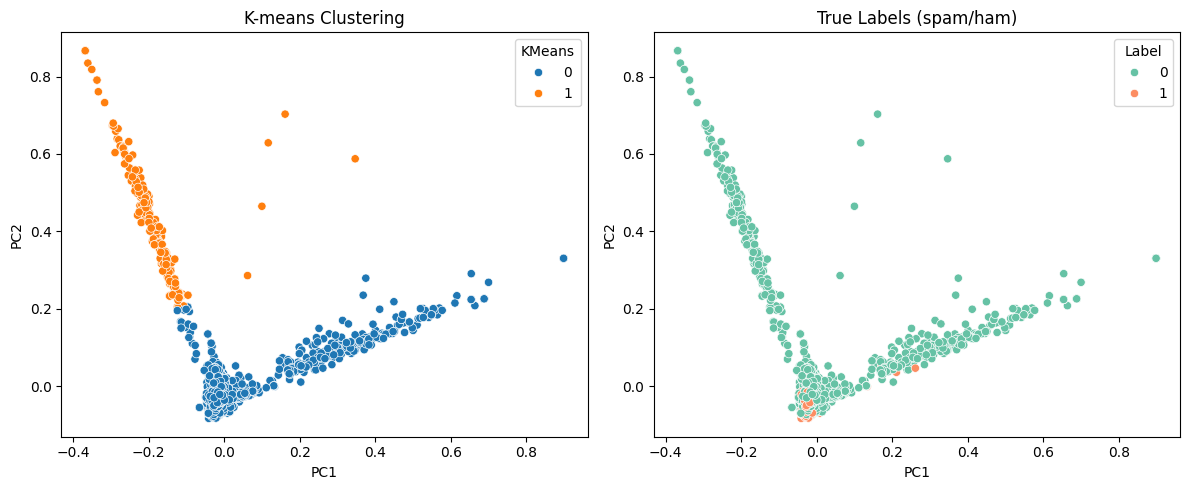

In [7]:
# Step 8: Prepare DataFrame for visualization
df_vis = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_vis['KMeans'] = kmeans_labels
df_vis['Hierarchical'] = hc_labels
df_vis['Label'] = LabelEncoder().fit_transform(df['target'])  # spam = 1, ham = 0

# Step 9: Plot K-means result
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(data=df_vis, x='PC1', y='PC2', hue='KMeans', palette='tab10')
plt.title("K-means Clustering")

# Plot actual labels
plt.subplot(1, 2, 2)
sns.scatterplot(data=df_vis, x='PC1', y='PC2', hue='Label', palette='Set2')
plt.title("True Labels (spam/ham)")

plt.tight_layout()
plt.show()

Page 81

In [ ]:
# Step 1: Install required libraries
!pip install -q gensim xgboost nltk

# Step 2: Imports
import pandas as pd
import numpy as np
import re
import string
import nltk
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec, KeyedVectors
from tqdm import tqdm

nltk.download('punkt')
nltk.download('stopwords')

# Step 3: Load data
from google.colab import files
uploaded = files.upload()
df = pd.read_csv(next(iter(uploaded)), encoding='latin1')[['text', 'target']].dropna()

# Step 4: Preprocess text
stop_words = set(stopwords.words('english'))
def clean_text(text):
    text = text.lower()
    text = re.sub(f"[{string.punctuation}]", "", text)
    tokens = word_tokenize(text)
    tokens = [w for w in tokens if w not in stop_words]
    return tokens

df['tokens'] = df['text'].apply(clean_text)

# Step 5: Train Word2Vec model
w2v_model = Word2Vec(sentences=df['tokens'], vector_size=100, window=5, min_count=1, workers=4)
w2v_model.train(df['tokens'], total_examples=len(df), epochs=10)

# Step 6: Average word vectors
def get_w2v_vector(tokens, model):
    valid = [w for w in tokens if w in model.wv]
    if len(valid) == 0:
        return np.zeros(model.vector_size)
    return np.mean(model.wv[valid], axis=0)

df['w2v_vec'] = df['tokens'].apply(lambda x: get_w2v_vector(x, w2v_model))

# Step 7: Prepare data for training
X = np.vstack(df['w2v_vec'].values)
y = (df['target'] == 'spam').astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 8: Train classifiers
models = {
    "Naive Bayes": MultinomialNB(),  # Needs positive values only
    "Random Forest": RandomForestClassifier(),
    "GBM": GradientBoostingClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

# Naive Bayes on scaled data
from sklearn.preprocessing import MinMaxScaler
X_train_nb = MinMaxScaler().fit_transform(X_train)
X_test_nb = MinMaxScaler().transform(X_test)

# Step 9: Evaluation
for name, model in models.items():
    if name == "Naive Bayes":
        model.fit(X_train_nb, y_train)
        y_pred = model.predict(X_test_nb)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    print(f"\n=== {name} ===")
    print(classification_report(y_test, y_pred, target_names=["ham", "spam"]))
